# Lecture 5: Batch Normalization and Residual Streams

In this lecture, we will discuss two important techniques that have been shown to be very effective in training deep neural networks: Batch Normalization and Residual Streams. We will discuss both of these techniques in detail and show how they can be used to improve the performance of deep neural networks.

### Importing libraries

In [17]:
import os
import sys

project_path = r"C:\\Users\\delta\\Documents\\GitHub\\LLM101n"
sys.path.insert(0, project_path)

In [18]:
import os
import matplotlib.pyplot as plt
import itertools
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from utils import load_text, set_seed, configure_device

### Configuration

In [19]:
@dataclass
class MLPConfig:
    root_dir: str = os.getcwd() + "/../../"
    dataset_path: str = "data/names.txt"
    device: torch.device = torch.device('cpu')  # Automatic device configuration

    # Tokenizer
    vocab_size: int = 0  # Set later

    # Model
    context_size: int = 3
    d_embed: int = 16
    d_hidden: int = 256

    # Training
    val_size: float = 0.1
    batch_size: int = 32
    max_steps: int = 1000
    lr: float = 0.01
    val_interval: int = 100

    seed: int = 101

config = MLPConfig()

## Reproducibility

In [20]:
set_seed(config.seed)

Random seed set to 101


## Device

In [21]:
config.device = configure_device()

Running on cpu


## Dataset

In [22]:
# Load text and split by lines
names = load_text(config.root_dir + config.dataset_path).splitlines()

Loaded text data from c:\Users\delta\Documents\GitHub\LLM101n\notebooks\Lectures/../../data/names.txt (length: 228145 characters).


## Tokenizer

In [23]:
chars = [chr(i) for i in range(97, 123)]  # all alphabet characters
chars.insert(0, ".")  # Add special token
config.vocab_size = len(chars)
str2idx = {char: idx for idx, char in enumerate(chars)}
idx2str = {idx: char for char, idx in str2idx.items()}

## Preprocessing

In [24]:
# Train-Val Split
train_names, val_names = train_test_split(names, test_size=config.val_size, random_state=config.seed)

In [25]:
class NamesDataset(Dataset):
    def __init__(self, _names, context_size):
        self.inputs, self.targets = [], []

        for name in _names:
            context = [0] * context_size

            for char in name + ".":
                idx = str2idx[char]
                self.inputs.append(context)
                self.targets.append(idx)
                context = context[1:] + [idx]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.inputs[idx])
        target_id = torch.tensor(self.targets[idx])
        return input_ids, target_id

train_dataset = NamesDataset(train_names, config.context_size)
val_dataset = NamesDataset(val_names, config.context_size)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

## Model

In [26]:
class MLP(nn.Module):
    def __init__(self, vocab_size, context_size, d_embed, d_hidden):
        super().__init__()
        self.C = nn.Parameter(torch.randn(vocab_size, d_embed))
        self.W1 = nn.Parameter(torch.randn(context_size * d_embed, d_hidden))
        self.b1 = nn.Parameter(torch.randn(d_hidden))
        self.W2 = nn.Parameter(torch.randn(d_hidden, vocab_size))
        self.b2 = nn.Parameter(torch.randn(vocab_size))

    def forward(self, x):  # x: (batch_size, context_size)
        # Embedding
        x_embed = self.C[x]  # (batch_size, context_size, d_embed)
        x = x_embed.view(x.size(0), -1)  # (batch_size, context_size * d_embed)

        # Hidden layer
        h = F.tanh(x @ self.W1 + self.b1)  # (batch_size, d_hidden)

        # Output layer
        logits = h @ self.W2 + self.b2  # (batch_size, vocab_size)
        return logits

In [27]:
# Initialize the model
mlp = MLP(config.vocab_size, config.context_size, config.d_embed, config.d_hidden)
mlp.to(config.device) # Move the model to the device
print(mlp)
print("Number of parameters:", sum(p.numel() for p in mlp.parameters()))

MLP()
Number of parameters: 19915


In [28]:
# Training
def train(
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        max_steps: int,
        lr: float,
        val_interval: int,
        device: torch.device
):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    steps = []
    train_losses = []
    val_losses = []
    train_iter = itertools.cycle(train_loader)  # Infinite dataloader

    for step in range(1, max_steps + 1):
        model.train()
        train_inputs, train_targets = next(train_iter)
        train_inputs, train_targets = train_inputs.to(device), train_targets.to(device)
        optimizer.zero_grad()
        logits = model(train_inputs)
        loss = F.cross_entropy(logits, train_targets)
        loss.backward()
        optimizer.step()
        steps.append(step)
        train_losses.append(loss.item())

        if step % val_interval == 0:
            model.eval()
            val_loss = 0.0
            total_samples = 0
            with torch.no_grad():
                for val_inputs, val_targets in val_loader:
                    val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                    val_logits = model(val_inputs)
                    batch_loss = F.cross_entropy(val_logits, val_targets)
                    val_loss += batch_loss.item() * val_inputs.size(0)
                    total_samples += val_inputs.size(0)
            val_loss /= total_samples
            val_losses.append(val_loss)
            print(f"Step {step}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss:.4f}")

        if step == 1:
            print(f"Initial Train Loss = {loss.item():.4f}")

    # Plot the loss
    plt.figure()
    plt.plot(steps, train_losses, label="Train")
    val_steps = [step for step in steps if step % val_interval == 0]
    plt.plot(val_steps, val_losses, label="Validation")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Initial Train Loss = 32.5348
Step 100: Train Loss = 24.1774, Val Loss = 20.3608
Step 200: Train Loss = 19.1702, Val Loss = 16.8662
Step 300: Train Loss = 10.7864, Val Loss = 14.7275
Step 400: Train Loss = 14.2160, Val Loss = 13.2797
Step 500: Train Loss = 12.1662, Val Loss = 12.2998
Step 600: Train Loss = 15.8062, Val Loss = 11.5175
Step 700: Train Loss = 14.4778, Val Loss = 10.9088
Step 800: Train Loss = 13.4683, Val Loss = 10.3655
Step 900: Train Loss = 10.6566, Val Loss = 9.9281
Step 1000: Train Loss = 9.0144, Val Loss = 9.5601


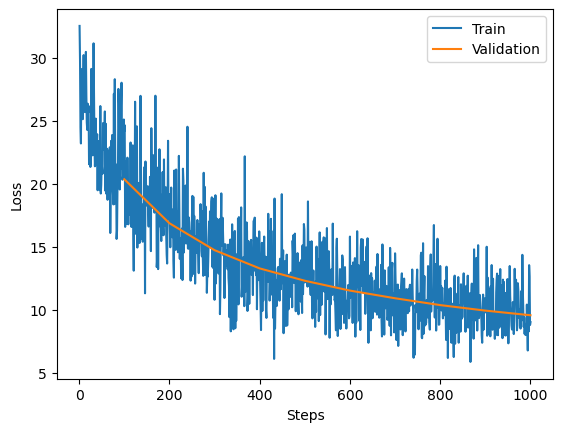

In [29]:
train(
    model=mlp,
    train_loader=train_loader,
    val_loader=val_loader,
    max_steps=config.max_steps,
    lr=config.lr,
    val_interval=config.val_interval,
    device=config.device
)

### Part 1: Batch Normalization

Recall what we do for initializing the weights of a neural network.

1. We don't want the logits to be too big because the softmax might explode.
- Initialize the final layer with small values.
2. We don't want the gradients to vanish.
- Initialize the inner layer with small values.
- Use different activation functions.

Eventually, what we want is to preserve the same gaussian distribution of the activations.

**Why not just normalize the activations?** -> Key idea to [Batch Normalization](https://arxiv.org/pdf/1502.03167)

In [30]:
# MLP Model with Batch Normalization
class MLP2(nn.Module):
    def __init__(self, vocab_size, context_size, d_embed, d_hidden):
        super().__init__()
        self.C = nn.Parameter(torch.randn(vocab_size, d_embed))
        self.W1 = nn.Parameter(torch.randn(context_size * d_embed, d_hidden))
        self.b1 = nn.Parameter(torch.randn(d_hidden))
        self.W2 = nn.Parameter(torch.randn(d_hidden, vocab_size))
        self.b2 = nn.Parameter(torch.randn(vocab_size))

        # Batch Normalization
        self.gamma = nn.Parameter(torch.ones(1, d_hidden))
        self.beta = nn.Parameter(torch.zeros(1, d_hidden))

    def forward(self, x):  # x: (batch_size, context_size)
        # Embedding
        x_embed = self.C[x]  # (batch_size, context_size, d_embed)
        x = x_embed.view(x.size(0), -1)  # (batch_size, context_size * d_embed)

        # Hidden layer
        x = x @ self.W1 + self.b1  # (batch_size, d_hidden)

        # Batch Normalization
        ################################################################################
        # TODO:                                                                        #
        # Implement the batch normalization for the hidden layer.                      #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        mean = x.mean(dim=0, keepdim=True)
        std = x.std(dim=0, keepdim=True) + 1e-8  # add small value to avoid division by zero
        x = self.gamma * (x - mean) / std + self.beta  # (batch_size, d_hidden)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        h = F.tanh(x)  # (batch_size, d_hidden)

        # Output layer
        logits = h @ self.W2 + self.b2  # (batch_size, vocab_size)
        return logits

In [31]:
# Initialize the model
mlp2 = MLP2(config.vocab_size, config.context_size, config.d_embed, config.d_hidden)
mlp2.to(config.device) # Move the model to the device
print(mlp2)
print("Number of parameters:", sum(p.numel() for p in mlp2.parameters()))

MLP2()
Number of parameters: 20427


Initial Train Loss = 20.5092
Step 100: Train Loss = 15.4263, Val Loss = 13.8811
Step 200: Train Loss = 14.5552, Val Loss = 11.2574
Step 300: Train Loss = 8.9287, Val Loss = 9.7377
Step 400: Train Loss = 9.8745, Val Loss = 8.5171
Step 500: Train Loss = 7.2062, Val Loss = 7.5893
Step 600: Train Loss = 8.2828, Val Loss = 6.8738
Step 700: Train Loss = 6.8111, Val Loss = 6.3159
Step 800: Train Loss = 5.1058, Val Loss = 5.9097
Step 900: Train Loss = 5.0835, Val Loss = 5.5433
Step 1000: Train Loss = 6.3539, Val Loss = 5.2432


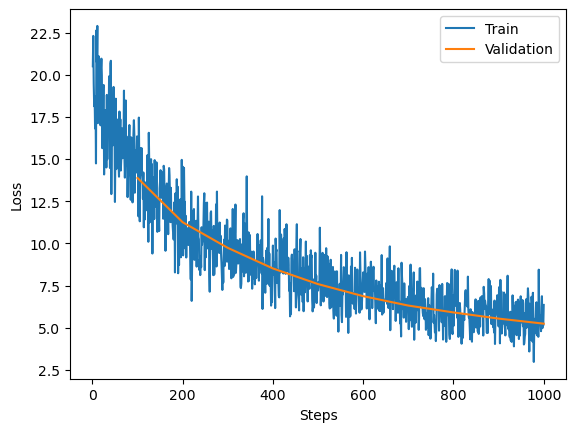

In [32]:
train(
    model=mlp2,
    train_loader=train_loader,
    val_loader=val_loader,
    max_steps=config.max_steps,
    lr=config.lr,
    val_interval=config.val_interval,
    device=config.device
)

Let's add more layers to the model.

In [33]:
# MLP Model with more layers
class MLP3(nn.Module):
    def __init__(self, vocab_size, context_size, d_embed, d_hidden, kaiming_init=False, batch_norm=False):
        super().__init__()
        # embedding layer
        self.C = nn.Parameter(torch.randn(vocab_size, d_embed))
        # hidden layers
        self.W1 = nn.Parameter(torch.randn(context_size * d_embed, d_hidden))
        self.W2 = nn.Parameter(torch.randn(d_hidden, d_hidden * 2))
        self.W3 = nn.Parameter(torch.randn(d_hidden * 2, d_hidden * 4))
        self.W4 = nn.Parameter(torch.randn(d_hidden * 4, d_hidden * 2))
        self.W5 = nn.Parameter(torch.randn(d_hidden * 2, d_hidden))
        # output layer
        self.W6 = nn.Parameter(torch.randn(d_hidden, vocab_size))
        ################################################################################
        # TODO:                                                                        #
        # Where did the biases go?                                                     #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.kaiming_init = kaiming_init
        if self.kaiming_init:
            nn.init.kaiming_normal_(self.W1, mode='fan_in', nonlinearity='tanh')
            nn.init.kaiming_normal_(self.W2, mode='fan_in', nonlinearity='tanh')
            nn.init.kaiming_normal_(self.W3, mode='fan_in', nonlinearity='tanh')
            nn.init.kaiming_normal_(self.W4, mode='fan_in', nonlinearity='tanh')
            nn.init.kaiming_normal_(self.W5, mode='fan_in', nonlinearity='tanh')

        # Batch Normalization
        self.batch_norm = batch_norm
        self.gamma1 = nn.Parameter(torch.ones(1, d_hidden))
        self.beta1 = nn.Parameter(torch.zeros(1, d_hidden))
        self.gamma2 = nn.Parameter(torch.ones(1, d_hidden * 2))
        self.beta2 = nn.Parameter(torch.zeros(1, d_hidden * 2))
        self.gamma3 = nn.Parameter(torch.ones(1, d_hidden * 4))
        self.beta3 = nn.Parameter(torch.zeros(1, d_hidden * 4))
        self.gamma4 = nn.Parameter(torch.ones(1, d_hidden * 2))
        self.beta4  = nn.Parameter(torch.zeros(1, d_hidden* 2))
        self.gamma5 = nn.Parameter(torch.ones(1, d_hidden))
        self.beta5  = nn.Parameter(torch.zeros(1, d_hidden))

    def forward(self, x):  # x: (batch_size, context_size)
        # Embedding
        x_embed = self.C[x]  # (batch_size, context_size, d_embed)
        x = x_embed.view(x.size(0), -1)  # (batch_size, context_size * d_embed)

        # Hidden layer 1
        x = x @ self.W1  # (batch_size, d_hidden)
        if self.batch_norm:
            mean = x.mean(dim=0, keepdim=True)
            std = x.std(dim=0, keepdim=True) + 1e-8
            x = self.gamma1 * (x - mean) / std + self.beta1
        h1 = F.tanh(x)

        # Hidden layer 2
        x = h1 @ self.W2
        if self.batch_norm:
            mean = x.mean(dim=0, keepdim=True)
            std = x.std(dim=0, keepdim=True) + 1e-8
            x = self.gamma2 * (x - mean) / std + self.beta2
        h2 = F.tanh(x)

        # Hidden layer 3
        x = h2 @ self.W3
        if self.batch_norm:
            mean = x.mean(dim=0, keepdim=True)
            std = x.std(dim=0, keepdim=True) + 1e-8
            x = self.gamma3 * (x - mean) / std + self.beta3
        h3 = F.tanh(x)

        # Hidden layer 4
        x = h3 @ self.W4  # (batch_size, d_hidden)
        if self.batch_norm:
            mean = x.mean(dim=0, keepdim=True)
            std  = x.std(dim=0, keepdim=True) + 1e-8
            x = self.gamma4 * (x - mean) / std + self.beta4
        h4 = torch.tanh(x)

        # Hidden layer 5
        x = h4 @ self.W5  # (batch_size, d_hidden)
        if self.batch_norm:
            mean = x.mean(dim=0, keepdim=True)
            std  = x.std(dim=0, keepdim=True) + 1e-8
            x = self.gamma5 * (x - mean) / std + self.beta5
        h5 = torch.tanh(x)

        # Output layer
        logits = h5 @ self.W6  # (batch_size, vocab_size)
        return logits

In [34]:
# mlp3 = Kaiming_init=False, BatchNorm=False
# mlp4 = Kaiming_init=True, BatchNorm=False
# mlp5 = Kaiming_init=True, BatchNorm=True

mlp3 = MLP3(config.vocab_size, config.context_size, config.d_embed, config.d_hidden, kaiming_init=False, batch_norm=False)
mlp3.to(config.device)

mlp4 = MLP3(config.vocab_size, config.context_size, config.d_embed, config.d_hidden, kaiming_init=True, batch_norm=False)
mlp4.to(config.device)

mlp5 = MLP3(config.vocab_size, config.context_size, config.d_embed, config.d_hidden, kaiming_init=True, batch_norm=True)
mlp5.to(config.device)

MLP3()

Initial Train Loss = 35.5079
Step 100: Train Loss = 30.6929, Val Loss = 30.4408
Step 200: Train Loss = 27.8355, Val Loss = 28.4311
Step 300: Train Loss = 28.3745, Val Loss = 26.7575
Step 400: Train Loss = 22.0419, Val Loss = 24.4845
Step 500: Train Loss = 19.1778, Val Loss = 24.8722
Step 600: Train Loss = 24.8492, Val Loss = 25.2740
Step 700: Train Loss = 22.2472, Val Loss = 23.3250
Step 800: Train Loss = 15.3182, Val Loss = 25.6976
Step 900: Train Loss = 25.9088, Val Loss = 23.7059
Step 1000: Train Loss = 24.7498, Val Loss = 27.1480


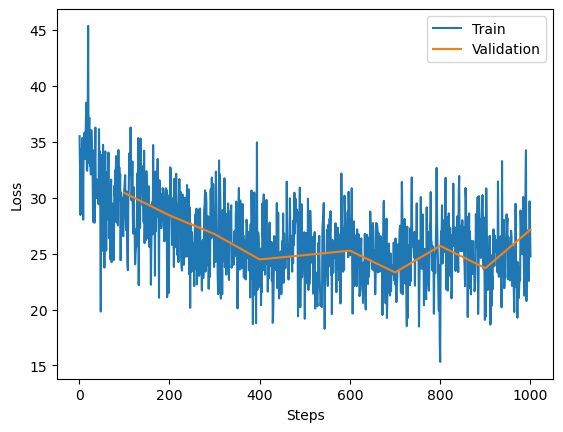

In [35]:
train(
    model=mlp3,
    train_loader=train_loader,
    val_loader=val_loader,
    max_steps=config.max_steps,
    lr=config.lr,
    val_interval=config.val_interval,
    device=config.device
)

Initial Train Loss = 22.0316
Step 100: Train Loss = 4.1543, Val Loss = 4.9649
Step 200: Train Loss = 3.6469, Val Loss = 3.3798
Step 300: Train Loss = 3.5238, Val Loss = 3.1398
Step 400: Train Loss = 2.6598, Val Loss = 2.9445
Step 500: Train Loss = 2.8119, Val Loss = 2.8064
Step 600: Train Loss = 2.4623, Val Loss = 2.7379
Step 700: Train Loss = 3.0336, Val Loss = 2.6885
Step 800: Train Loss = 3.0165, Val Loss = 2.6361
Step 900: Train Loss = 2.5843, Val Loss = 2.6307
Step 1000: Train Loss = 1.9826, Val Loss = 2.6647


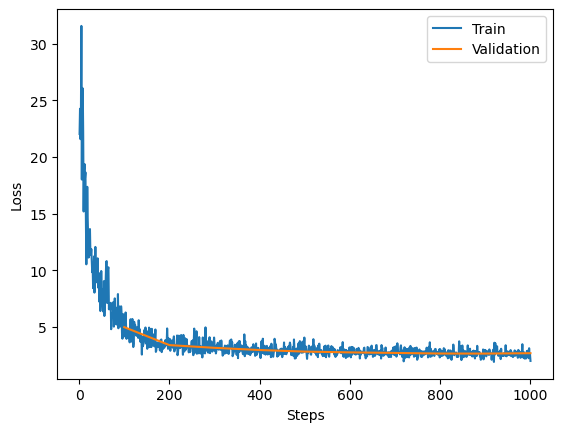

In [36]:
train(
    model=mlp4,
    train_loader=train_loader,
    val_loader=val_loader,
    max_steps=config.max_steps,
    lr=config.lr,
    val_interval=config.val_interval,
    device=config.device
)

Initial Train Loss = 21.8789
Step 100: Train Loss = 4.3637, Val Loss = 4.0096
Step 200: Train Loss = 3.7690, Val Loss = 3.0688
Step 300: Train Loss = 3.0973, Val Loss = 2.8807
Step 400: Train Loss = 2.3428, Val Loss = 2.7252
Step 500: Train Loss = 2.8770, Val Loss = 2.6494
Step 600: Train Loss = 2.8888, Val Loss = 2.5604
Step 700: Train Loss = 2.2993, Val Loss = 2.5605
Step 800: Train Loss = 2.6405, Val Loss = 2.4621
Step 900: Train Loss = 2.6065, Val Loss = 2.4940
Step 1000: Train Loss = 2.5653, Val Loss = 2.4548


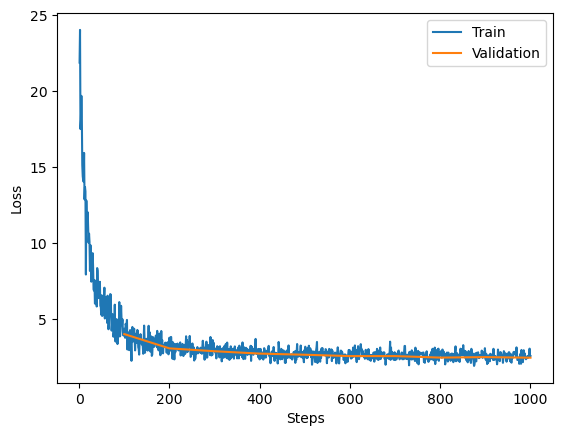

In [37]:
train(
    model=mlp5,
    train_loader=train_loader,
    val_loader=val_loader,
    max_steps=config.max_steps,
    lr=config.lr,
    val_interval=config.val_interval,
    device=config.device
)

In [38]:
def plot_gradients(model):
    named_params = list(model.named_parameters())

    plt.figure(figsize=(20, 4))
    legends = []

    for name, p in named_params:
        if p.requires_grad and p.grad is not None:
            if p.ndim == 2 and not ('gamma' in name or 'beta' in name) and name in ['W1', 'W2', 'W3', 'W4', 'W5']:
                t = p.grad.cpu()
                weight_std = p.cpu().std() + 1e-8
                print('weight %10s (%s) | mean %+f | std %e | gradient:weight ratio %e' %
                      (tuple(p.shape), name, t.mean(), t.std(), t.std() / weight_std))

                hy, hx = torch.histogram(t, bins=30, density=True)
                plt.plot(hx[:-1].detach(), hy.detach())
                legends.append(f'{name} {tuple(p.shape)}')

    plt.legend(legends)
    plt.title('Weights Gradient Distribution')
    plt.xlabel('Gradient Value')
    plt.ylabel('Density')
    plt.show()
    plt.figure(figsize=(20, 4))

weight  (48, 256) (W1) | mean -0.268302 | std 9.364984e+00 | gradient:weight ratio 3.504700e+00
weight (256, 512) (W2) | mean +0.002282 | std 9.528592e-01 | gradient:weight ratio 8.977197e-01
weight (512, 1024) (W3) | mean +0.000480 | std 3.026256e-01 | gradient:weight ratio 3.019187e-01
weight (1024, 512) (W4) | mean -0.000070 | std 7.495852e-02 | gradient:weight ratio 7.498883e-02
weight (512, 256) (W5) | mean -0.000127 | std 3.914090e-02 | gradient:weight ratio 3.918789e-02


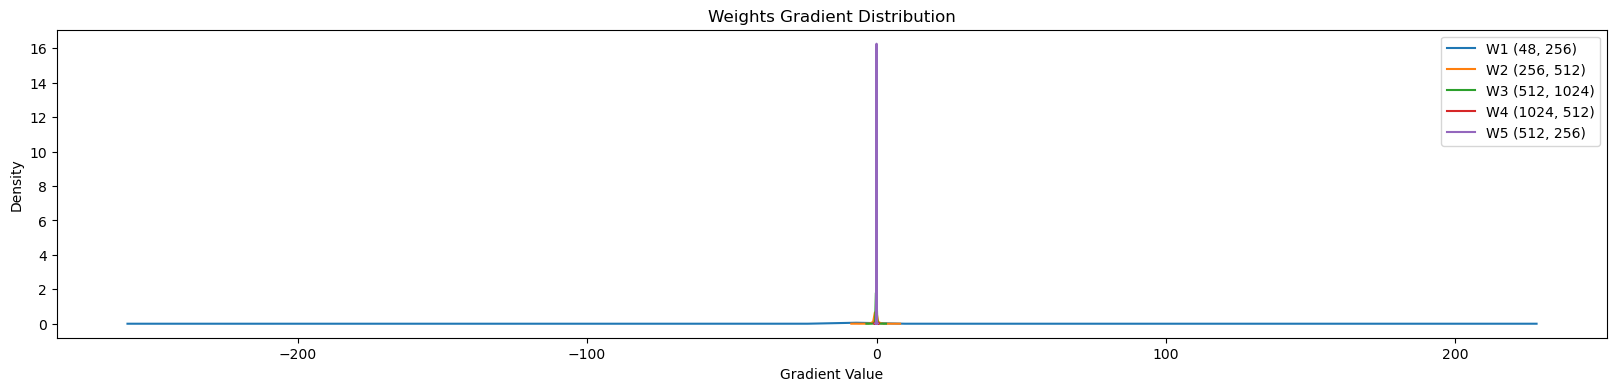

<Figure size 2000x400 with 0 Axes>

In [39]:
plot_gradients(mlp3)

weight  (48, 256) (W1) | mean +0.000001 | std 7.385456e-03 | gradient:weight ratio 7.015216e-02
weight (256, 512) (W2) | mean +0.000008 | std 2.730139e-03 | gradient:weight ratio 3.696478e-02
weight (512, 1024) (W3) | mean -0.000004 | std 2.259526e-03 | gradient:weight ratio 4.326924e-02
weight (1024, 512) (W4) | mean -0.000001 | std 2.420185e-03 | gradient:weight ratio 3.284441e-02
weight (512, 256) (W5) | mean -0.000031 | std 7.407507e-03 | gradient:weight ratio 7.116337e-02


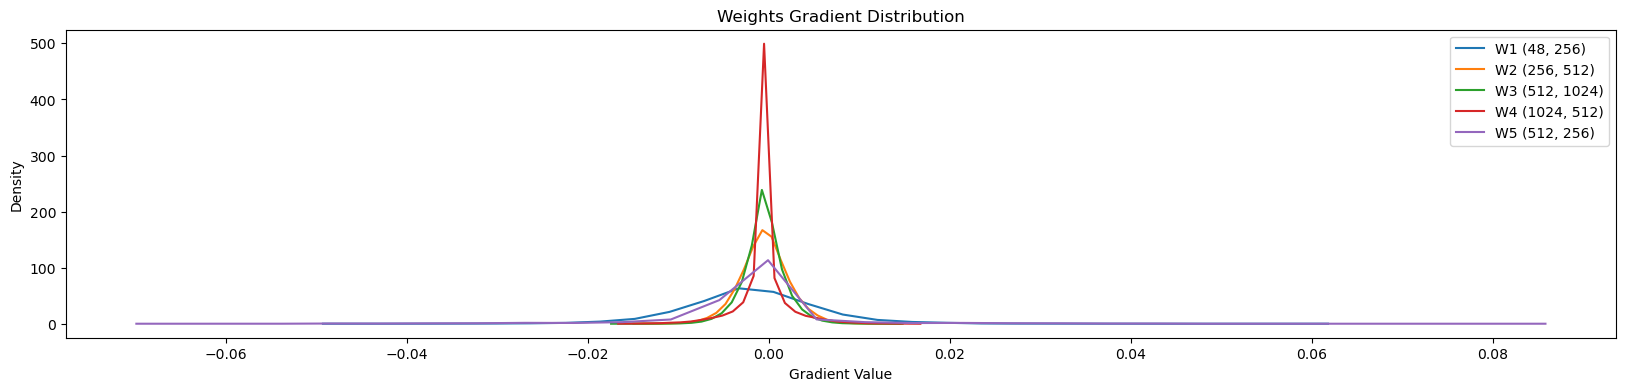

<Figure size 2000x400 with 0 Axes>

In [40]:
plot_gradients(mlp4)

weight  (48, 256) (W1) | mean +0.000045 | std 1.278396e-02 | gradient:weight ratio 1.213825e-01
weight (256, 512) (W2) | mean -0.000021 | std 5.412159e-03 | gradient:weight ratio 7.339156e-02
weight (512, 1024) (W3) | mean +0.000005 | std 4.327269e-03 | gradient:weight ratio 8.274081e-02
weight (1024, 512) (W4) | mean -0.000006 | std 4.108440e-03 | gradient:weight ratio 5.574943e-02
weight (512, 256) (W5) | mean +0.000037 | std 1.169855e-02 | gradient:weight ratio 1.121595e-01


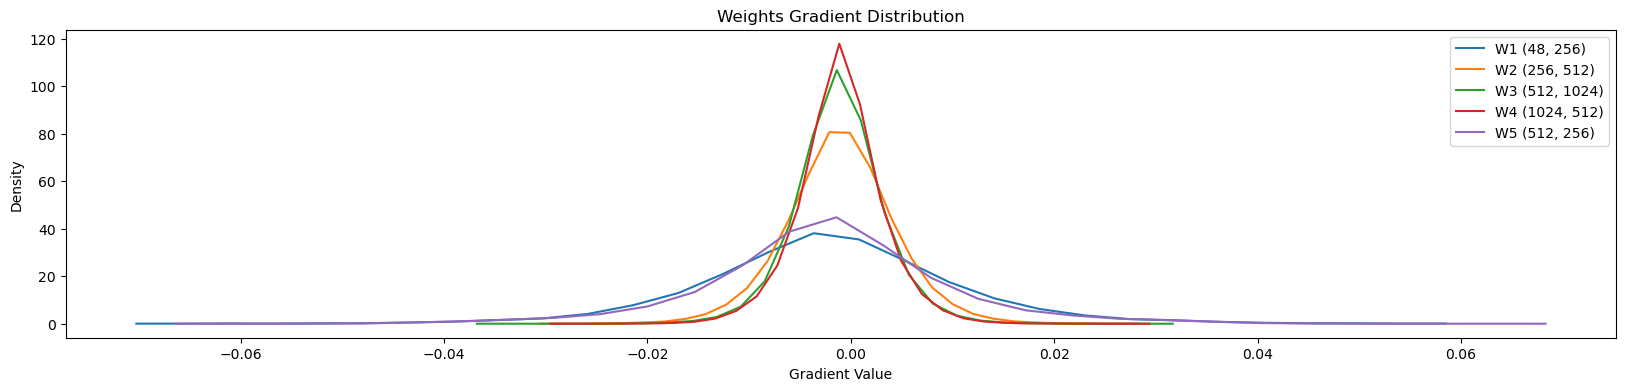

<Figure size 2000x400 with 0 Axes>

In [41]:
plot_gradients(mlp5)

So basically what batch normalization is doing...
- It normalizes the activations by subtracting the mean and dividing by the standard deviation.
    - How do you get the mean and standard deviation?
    - You calculate them for each feature over the batch.
        - What about the test time? Batch size is 1.
        - You calculate the entire mean and standard deviation over the training set. Use that for test time.



In [42]:
# TODO: Batch Normalization for Test Time

### Part 2: Residual Streams

One more idea to avoid vanishing gradients is to use **skip connections**.

![Residual Streams](../../assets/residual.png)

Recall what backpropagation does:
- It sends the gradients to the weights of the previous layer over and over again.
- As the number of layers increases, the gradients become smaller and smaller.
- Eventually, the gradients become too small to update the weights.
- The network stops learning.

**Residual Streams** solve this problem by adding the input to the output.


In [43]:
class DeepMLP(nn.Module):
    def __init__(self, vocab_size, context_size, d_embed, d_hidden, n_layers, residual=False):
        super().__init__()
        self.residual = residual

        self.C = nn.Parameter(torch.randn(vocab_size, d_embed))

        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.layers.append(nn.Linear(context_size * d_embed, d_hidden))
        self.batch_norms.append(nn.BatchNorm1d(d_hidden))
        for _ in range(n_layers - 1):
            self.layers.append(nn.Linear(d_hidden, d_hidden))
            self.batch_norms.append(nn.BatchNorm1d(d_hidden))

        self.out = nn.Linear(d_hidden, vocab_size)

    def forward(self, x):
        # Embedding
        x_embed = self.C[x]  # (batch_size, context_size, d_embed)
        x = x_embed.view(x.size(0), -1)  # (batch_size, context_size * d_embed)

        x = self.layers[0](x)
        x = self.batch_norms[0](x)
        x = F.tanh(x)
        for layer, bn in zip(self.layers[1:], self.batch_norms[1:]):
            residual = x  # Save the input for the skip connection.
            x = layer(x)
            x = bn(x)
            x = F.tanh(x)
            if self.residual:
                x = x + residual  # Add the skip connection.

        logits = self.out(x)
        return logits

In [44]:
# Initialize the model
deep_mlp = DeepMLP(config.vocab_size, config.context_size, config.d_embed, config.d_hidden, n_layers=50, residual=False)
deep_mlp.to(config.device) # Move the model to the device
print(deep_mlp)
print("Number of parameters:", sum(p.numel() for p in deep_mlp.parameters()))

DeepMLP(
  (layers): ModuleList(
    (0): Linear(in_features=48, out_features=256, bias=True)
    (1-49): 49 x Linear(in_features=256, out_features=256, bias=True)
  )
  (batch_norms): ModuleList(
    (0-49): 50 x BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (out): Linear(in_features=256, out_features=27, bias=True)
)
Number of parameters: 3269323


In [45]:
# Initialize the model
deep_mlp_res = DeepMLP(config.vocab_size, config.context_size, config.d_embed, config.d_hidden, n_layers=50, residual=True)
deep_mlp_res.to(config.device) # Move the model to the device
print(deep_mlp_res)
print("Number of parameters:", sum(p.numel() for p in deep_mlp_res.parameters()))

DeepMLP(
  (layers): ModuleList(
    (0): Linear(in_features=48, out_features=256, bias=True)
    (1-49): 49 x Linear(in_features=256, out_features=256, bias=True)
  )
  (batch_norms): ModuleList(
    (0-49): 50 x BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (out): Linear(in_features=256, out_features=27, bias=True)
)
Number of parameters: 3269323


Initial Train Loss = 3.3517
Step 100: Train Loss = 3.1888, Val Loss = 3.1140
Step 200: Train Loss = 2.6905, Val Loss = 2.9483
Step 300: Train Loss = 3.3998, Val Loss = 2.8378
Step 400: Train Loss = 2.8728, Val Loss = 2.7913
Step 500: Train Loss = 2.5468, Val Loss = 2.8511
Step 600: Train Loss = 2.7770, Val Loss = 2.6881
Step 700: Train Loss = 2.1774, Val Loss = 2.7069
Step 800: Train Loss = 2.4774, Val Loss = 2.6139
Step 900: Train Loss = 2.2703, Val Loss = 2.6407
Step 1000: Train Loss = 2.4462, Val Loss = 2.5839


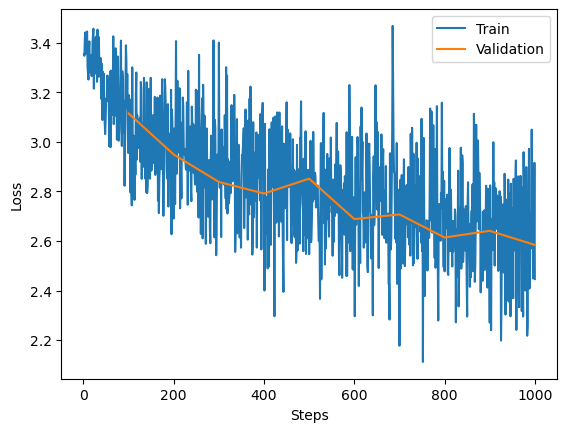

In [46]:
train(
    model=deep_mlp,
    train_loader=train_loader,
    val_loader=val_loader,
    max_steps=config.max_steps,
    lr=config.lr,
    val_interval=config.val_interval,
    device=config.device
)

Initial Train Loss = 6.4563
Step 100: Train Loss = 3.2854, Val Loss = 3.2552
Step 200: Train Loss = 2.9392, Val Loss = 2.7880
Step 300: Train Loss = 3.1528, Val Loss = 2.7687
Step 400: Train Loss = 2.8102, Val Loss = 2.6296
Step 500: Train Loss = 2.9499, Val Loss = 2.6304
Step 600: Train Loss = 2.8069, Val Loss = 2.5051
Step 700: Train Loss = 2.3986, Val Loss = 2.5040
Step 800: Train Loss = 2.5019, Val Loss = 2.4783
Step 900: Train Loss = 2.9059, Val Loss = 2.4908
Step 1000: Train Loss = 2.4553, Val Loss = 2.4597


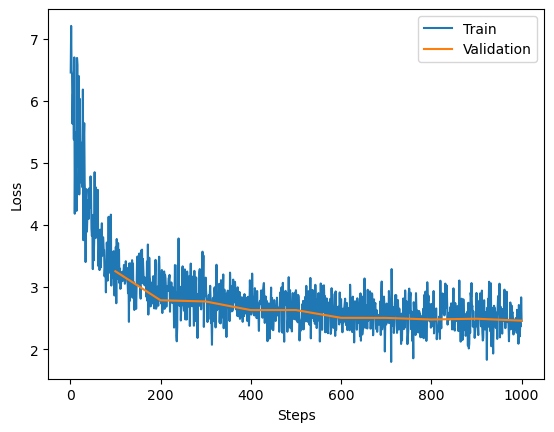

In [47]:
train(
    model=deep_mlp_res,
    train_loader=train_loader,
    val_loader=val_loader,
    max_steps=config.max_steps,
    lr=config.lr,
    val_interval=config.val_interval,
    device=config.device
)

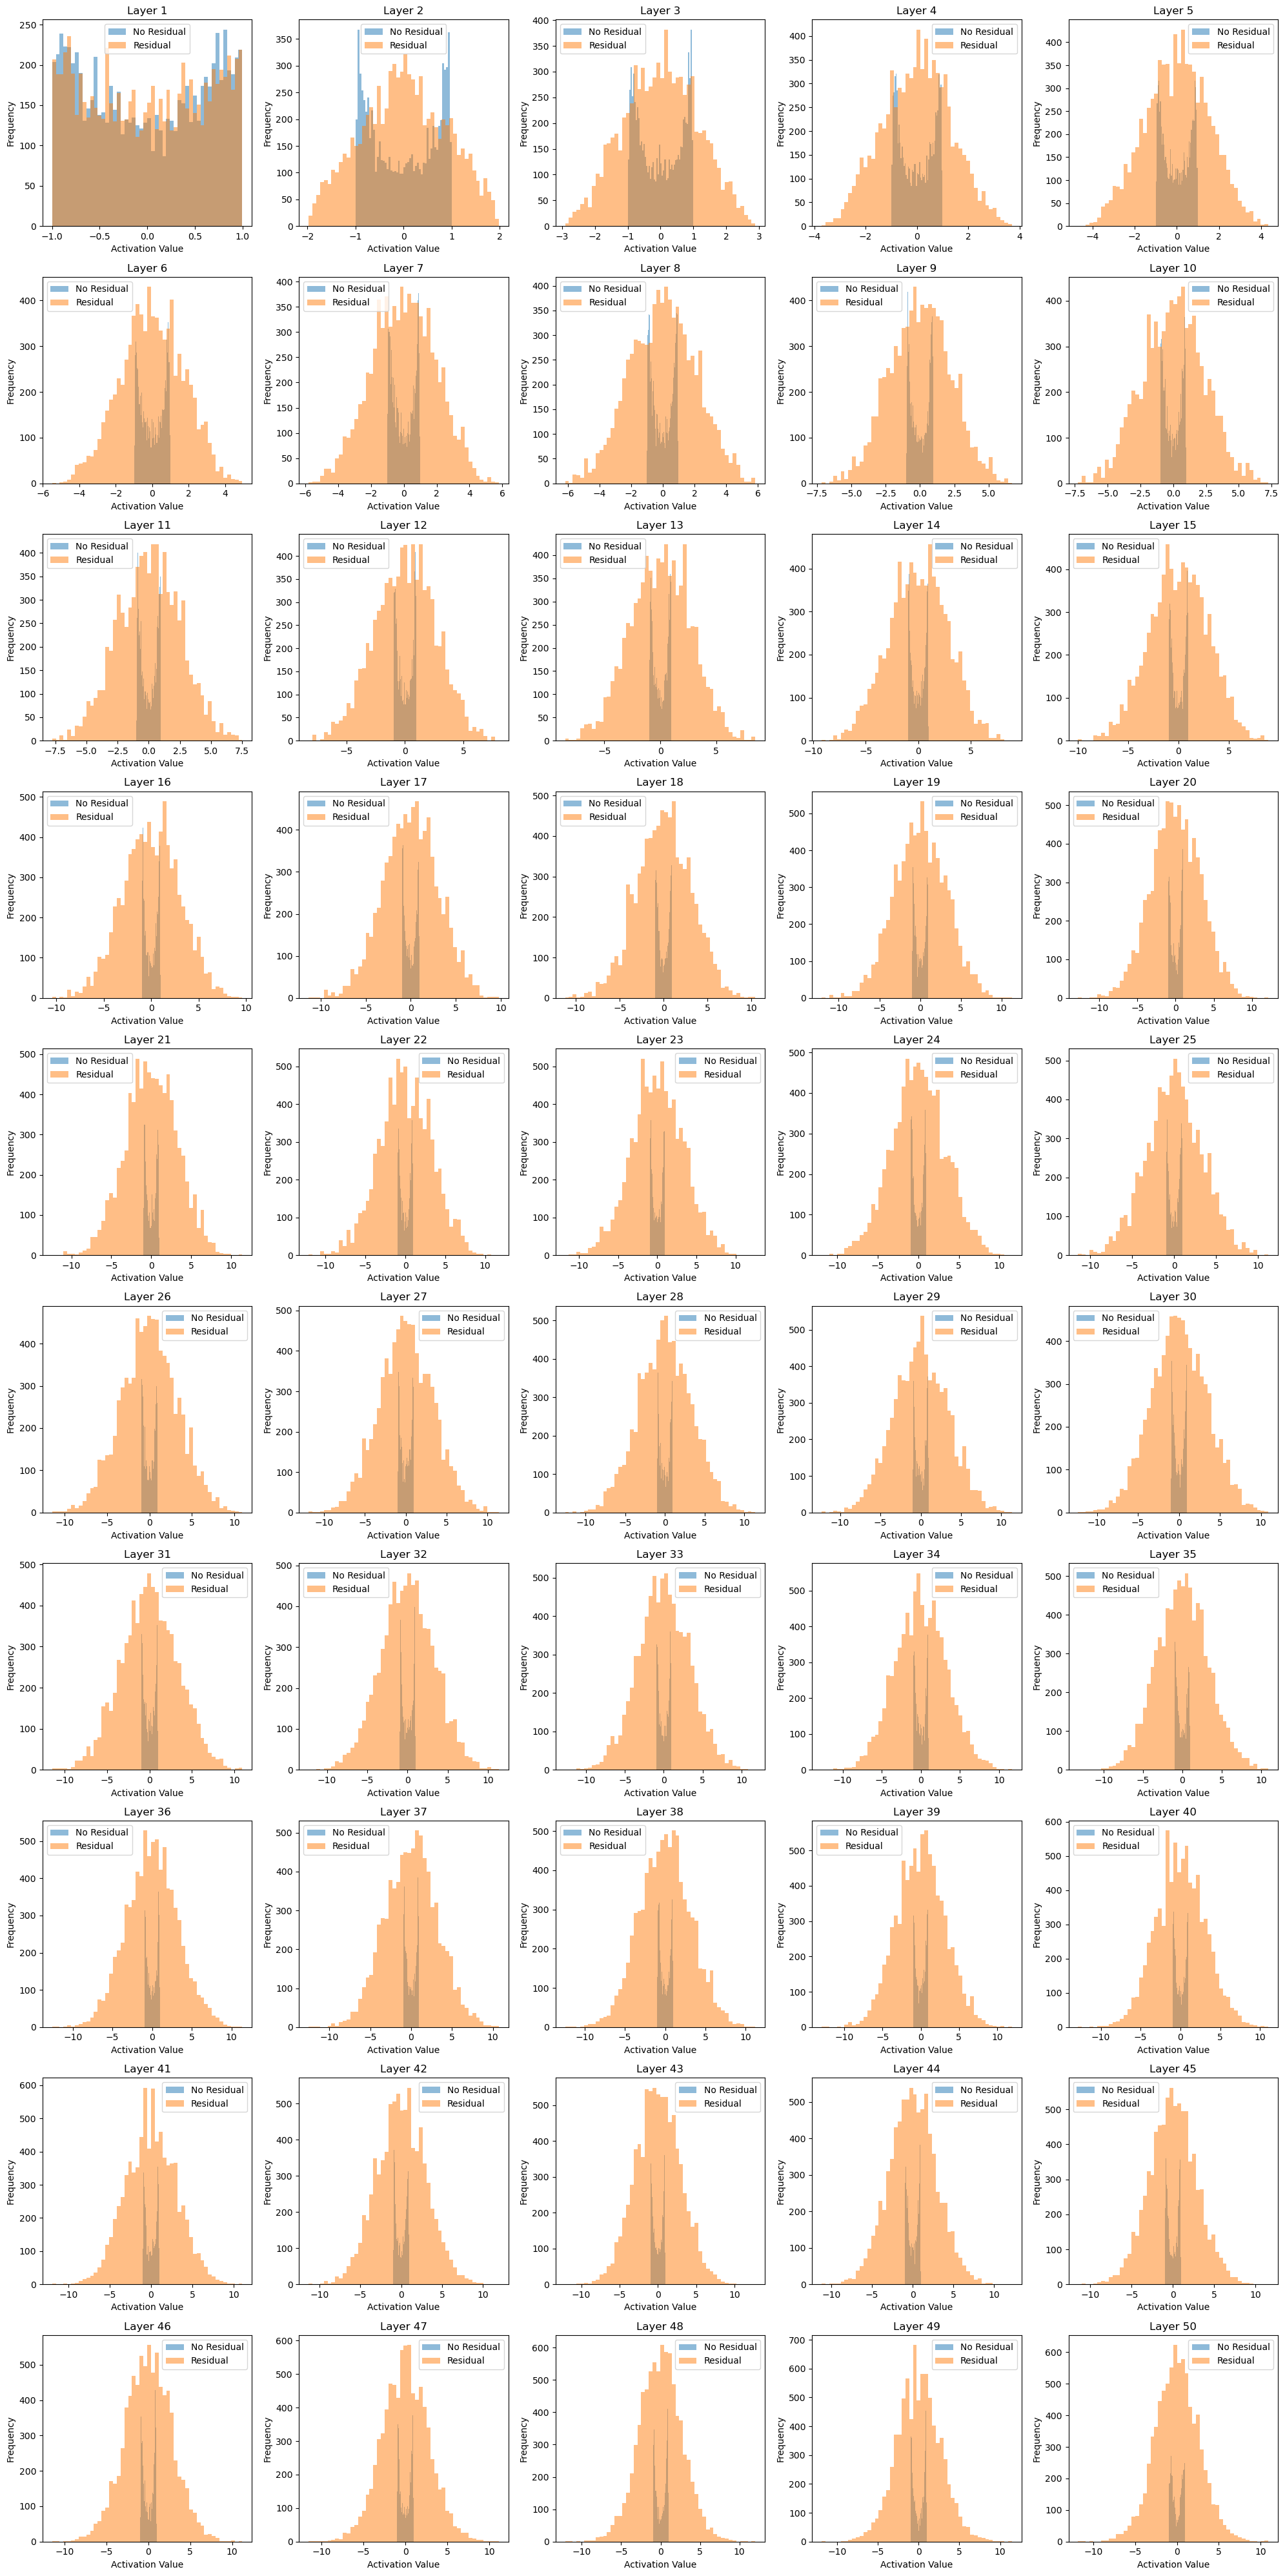

In [48]:
def get_activations(model, x):
    activations = {}
    x_embed = model.C[x]
    x_flat = x_embed.view(x.size(0), -1)

    a = model.layers[0](x_flat)
    a = model.batch_norms[0](a)
    a = F.tanh(a)
    activations["Layer 1"] = a.detach().cpu().numpy()

    for idx, (layer, bn) in enumerate(zip(model.layers[1:], model.batch_norms[1:]), start=2):
        residual = a
        a = layer(a)
        a = bn(a)
        a = F.tanh(a)
        if model.residual:
            a = a + residual
        activations[f"Layer {idx}"] = a.detach().cpu().numpy()

    return activations

# Sample a batch from the train_loader.
sample = next(iter(train_loader))[0]

# Get activations for both non-residual and residual models.
acts_no_res = get_activations(deep_mlp, sample)
acts_res = get_activations(deep_mlp_res, sample)

# Plot the activation histograms.
import math
cols = 5
rows = math.ceil(len(acts_no_res) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
axes = axes.flatten()

for idx, layer in enumerate(acts_no_res.keys()):
    axes[idx].hist(acts_no_res[layer].flatten(), bins=50, alpha=0.5, label='No Residual')
    axes[idx].hist(acts_res[layer].flatten(), bins=50, alpha=0.5, label='Residual')
    axes[idx].set_title(layer)
    axes[idx].set_xlabel("Activation Value")
    axes[idx].set_ylabel("Frequency")
    axes[idx].legend()

# Turn off any extra subplots.
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Conclusion

Deep, deep neural networks is all about optimization.
- [VGGNet, 2014](https://arxiv.org/pdf/1409.1556): 19 layers ("very deep" for 19 layers...)
- [ResNet, 2015](https://arxiv.org/pdf/1512.03385): 152 layers
- [GPT-3, 2020](https://arxiv.org/pdf/2005.14165): 96 layers

Why didn't researchers add layers for better performance before?

**Because it wasn't optimizable.**

Batch Normalization and Residual Streams are two key techniques that made it possible to train deep neural networks such as **Transformers**.



In [49]:
# TODO: Reproduce VGGNet, ResNet and compare the results.